In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from embedding_utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

### Data & Model Parameters

In [ ]:
smiles = fetch_smiles_gdb13('./data/gdb13').values.tolist()

for i, smile in enumerate(smiles):
    smiles[i] = smile.replace('Cl', 'L')
    
vocab = ['<pad>'] + sorted(list({c for smile in smiles for c in smile}))

ctoi = {c: i for i, c in enumerate(vocab)}

In [ ]:
smiles_sample = random.sample(smiles, 100)

# Create index-wise vectorization
    
vectorized_smiles = [torch.Tensor([ctoi.get(c) for c in smile]) for smile in smiles]

smiles_lengths = [len(smile) for smile in vectorized_smiles]

# Create Padded Tensor

max_len = max(len(smile) for smile in smiles)

smiles_tensor = torch.zeros(size=(len(vectorized_smiles), max_len), dtype=torch.int)
for i, smile in enumerate(vectorized_smiles):
    smiles_tensor[i, :len(smile)] = smile

# Pack

return nn.utils.rnn.pack_padded_sequence(smiles_tensor, smiles_lengths, batch_first=True)

### Model

In [ ]:
params = make_params(smiles=smiles, GRU_HIDDEN_DIM=256, LATENT_DIM=128)

In [ ]:
encoder = Encoder(params)
encoder.load_state_dict(torch.load('weights/encoder_weights.pth'))

decoder = Decoder(params)
decoder.load_state_dict(torch.load('weights/decoder_weights.pth'))

In [ ]:
test_smile = ["S2C=CC=C1"]
x = smiles[2]
print(x)
x = to_one_hot(x, params)
y = to_one_hot(test_smile, params)

In [ ]:
encoder = Encoder(params)

z_mean, z_logvar, z = encoder(x)
y_hat = decoder(z)

plt.imshow(torch.softmax(y_hat, dim=2).squeeze(0).detach().numpy())

In [ ]:
CE_loss = nn.CrossEntropyLoss()
KL_divergence = lambda z_mean, z_logvar : -0.5 * torch.mean(1 + z_logvar - z_mean ** 2 - torch.exp(z_logvar))
CE_loss(y_hat.transpose(1, 2), torch.argmax(x, dim=2))

## Test

In [ ]:
evaluate_ae(encoder, decoder, smiles, 1000, params=params)

In [21]:
log = pd.read_csv('train_output/log-1-9.csv')

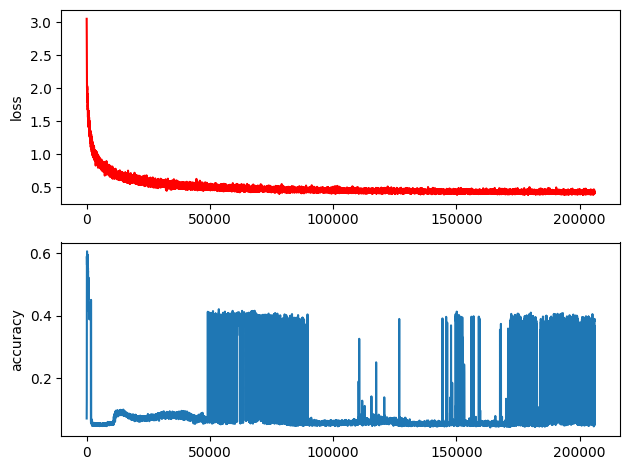

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_ylabel('loss')
ax1.plot(log['i'], log['loss'], color='red')

ax2.set_ylabel('accuracy')
ax2.plot(log['i'], log['similarity'])

fig.tight_layout()